In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) #set figsize for all

### Read data and concat

Two sources:
* 1969-1988: Center for Disease Control from Jake Vpd
* 1994-2014: Two sets from FiveThirtyEight
  - Center for Disease Control (1994-2003)
  - Social Security (2004-2014)

In [2]:
# First set
vpd = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv').groupby(['year', 'month', 'day'])['births'].sum().reset_index()
vpd['day'] = vpd['day'].astype(int)
# need to remove a few invalid dates with sigma clipping from Jake VPD's code
quartiles = np.percentile(vpd['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.7413 * (quartiles[2] - quartiles[0])
vpd = vpd.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

# Second set
fte_cdc = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_1994-2003_CDC_NCHS.csv')
fte_ss = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_2000-2014_SSA.csv')
fte = pd.concat([fte_cdc, fte_ss[fte_ss['year'] > 2003]], axis=0) #concat two 538 sets
fte = fte.drop(columns=['day_of_week']).rename(columns = {'date_of_month':'day'}) #rename to get same column names

# Concat
birth_df = pd.concat([vpd, fte], axis=0)

In [3]:
birth_df.head()

,year,month,day,births
0,1969,1,1,8486
1,1969,1,2,9002
2,1969,1,3,9542
3,1969,1,4,8960
4,1969,1,5,8390


### Plot birthdays

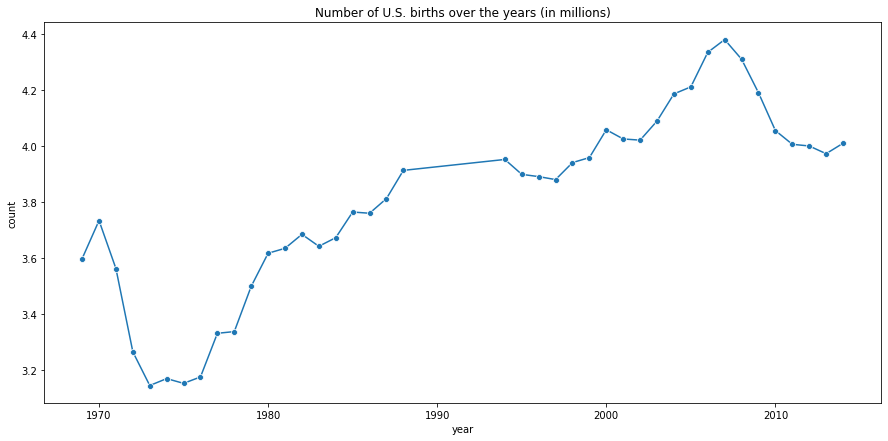

In [4]:
#Plot
data = birth_df.groupby('year')['births'].sum().reset_index(name='count')

ax = sns.lineplot(x=data['year'], y=data['count']/np.power(10, 6), marker='o')
ax.set_title('Number of U.S. births over the years (in millions)')
plt.show()

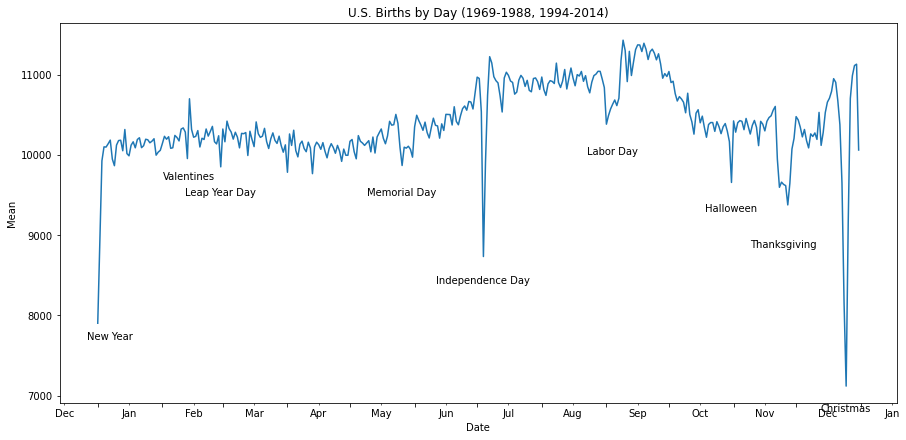

In [5]:
# Get date (pick leap year as placeholder)
birth_df['date'] = pd.to_datetime('2012-'+birth_df['month'].astype(str)+'-'+birth_df['day'].astype(str))
data = birth_df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')

# Plot
ax = sns.lineplot(x=data['date'], y=data['mean'])
ax.set(title='U.S. Births by Day (1969-1988, 1994-2014)', ylabel='Mean', xlabel='Date')

# day labels
ax.text(datetime.datetime(2012, 1, 7), 7700, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 9700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 9500, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 9500, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 10000, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9300, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 8850, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 6800, "Christmas", ha='center')

# adjust x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

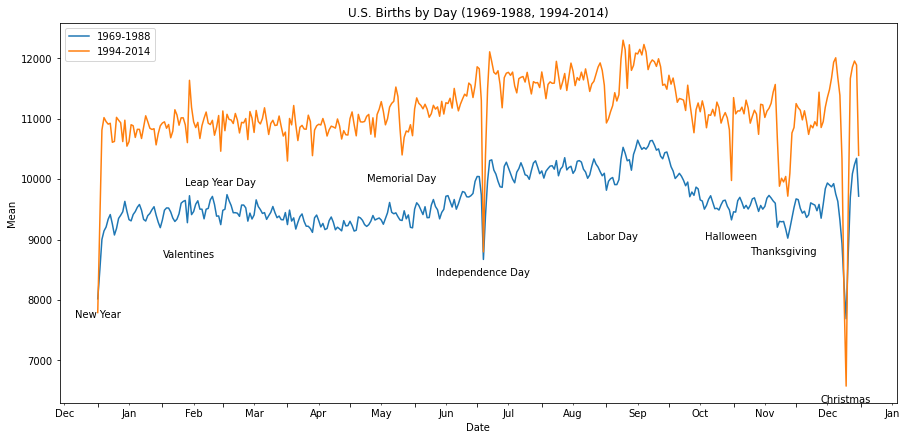

In [6]:
# Has trend changed? Compared the two periods
fig, ax = plt.subplots()

for i, df in enumerate([vpd, fte]):
    df['date'] = pd.to_datetime('2012-'+df['month'].astype(str)+'-'+df['day'].astype(str))
    data = df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')
     
    sns.lineplot(x=data['date'], y=data['mean'], ax=ax)    
    
ax.text(datetime.datetime(2012, 1, 1), 7700, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 8700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 9900, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 9950, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 9000, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9000, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 8750, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 6300, "Christmas", ha='center')

ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

ax.set(title='U.S. Births by Day (1969-1988, 1994-2014)', ylabel='Mean', xlabel='Date')
ax.legend(['1969-1988','1994-2014'])
plt.show()

Some biggest differences in the 21st Century:
- More babies are born
- More births on Valentine's
- BIG drops on major holidays: New Year, Memorial, 4th July, Labor, Halloween, Thanksviging, and Christmas -- Americans take holidays more seriously?

### Understand conception periods

#### By pure dates

In [83]:
# Get conceived dates
birth_df['date'] = [datetime.datetime(year, month, day) for (year, month, day) in zip(birth_df['year'], birth_df['month'], birth_df['day'])]
birth_df['conceived_date'] = birth_df['date'] - datetime.timedelta(days=280) #40 weeks
birth_df['dayofweek'] = birth_df['conceived_date'].dt.strftime('%A')
birth_df.head()

,year,month,day,births,date,conceived_date,dayofweek,conceived_start,conceived_end
0,1969,1,1,8486,1969-01-01,1968-03-27,Wednesday,March 27,April 10
1,1969,1,2,9002,1969-01-02,1968-03-28,Thursday,March 28,April 11
2,1969,1,3,9542,1969-01-03,1968-03-29,Friday,March 29,April 12
3,1969,1,4,8960,1969-01-04,1968-03-30,Saturday,March 30,April 13
4,1969,1,5,8390,1969-01-05,1968-03-31,Sunday,March 31,April 14


In [86]:
# Group by
birth_df['conceived_date'] = birth_df['conceived_date'].dt.strftime('%b %d')
data = birth_df.groupby(['conceived_date', 'dayofweek'])['births'].mean().reset_index(name='mean')
data.head()

,conceived_date,dayofweek,mean
0,Apr 01,Friday,11167.600000
1,Apr 01,Monday,10225.833333
2,Apr 01,Saturday,8580.000000
3,Apr 01,Sunday,7694.833333
4,Apr 01,Thursday,10891.571429


In [87]:
# Get dummies
for col in ['dayofweek', 'conceived_date']:
    dummy = pd.get_dummies(data[col])
    data = pd.concat([data, dummy], axis=1)

data = data.drop(columns=['conceived_date', 'dayofweek', 'Jan 01', 'Monday']) #drop Jan 01, Monday as they are our base
data.head()

,mean,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr 01,Apr 02,Apr 03,...,Sep 21,Sep 22,Sep 23,Sep 24,Sep 25,Sep 26,Sep 27,Sep 28,Sep 29,Sep 30
0,11167.600000,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10225.833333,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8580.000000,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7694.833333,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10891.571429,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
Y = data['mean']
X = data[data.columns[1:]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     99.83
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        22:19:33   Log-Likelihood:                -18657.
No. Observations:                2561   AIC:                         3.806e+04
Df Residuals:                    2189   BIC:                         4.023e+04
Df Model:                         371                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.093e+04    145.444     75.122      0.000    1.06e+04    1.12e+04
Friday       484.6217     28.216     17.176      0.000     429.290     539.954
Saturday   -2124.5234     28.238    -75.236      0.000   -2179.900   -2069.147
Sunday     -2833.3801     28.216   -100.419      0.000   -2888.712   -2778.048
Thursday     516.5407     28.216     18.307      0.000     461.209     571.873
Tuesday      833.8978     28.216     29.555      0.000     778.566     889.230
Wednesday    590.6827     28.216     20.935      0.000     535.351     646.015
Apr 01      -454.9299    204.024     -2.230      0.026    -855.030     -54.830
Apr 02      -496.2510    204.024     -2.432      0.015    -896.351     -96.151
Apr 03      -614.8483    204.024     -3.014      0.003   -1014.949    -214.748
Apr 04      -656.7259    204.024     -3.219      0.001   -1056.826    -256.626
Apr 05      -411.3483    204.024     -2.016      0.044    -811.449     -11.248
Apr 06      -296.7646    204.024     -1.455      0.146    -696.865     103.336
Apr 07      -325.4673    204.024     -1.595      0.111    -725.568      74.633
Apr 08      -548.4422    204.024     -2.688      0.007    -948.542    -148.342
Apr 09      -366.4354    204.024     -1.796      0.073    -766.536      33.665
Apr 10      -550.7673    204.024     -2.700      0.007    -950.868    -150.667
Apr 11      -534.1286    204.024     -2.618      0.009    -934.229    -134.028
Apr 12      -407.6721    204.024     -1.998      0.046    -807.772      -7.572
Apr 13      -307.2782    204.024     -1.506      0.132    -707.378      92.822
Apr 14      -418.9279    204.024     -2.053      0.040    -819.028     -18.828
Apr 15      -406.8252    204.024     -1.994      0.046    -806.925      -6.725
Apr 16      -464.1469    204.024     -2.275      0.023    -864.247     -64.047
Apr 17      -473.6796    204.024     -2.322      0.020    -873.780     -73.579
Apr 18      -404.1361    204.024     -1.981      0.048    -804.236      -4.036
Apr 19      -342.0116    204.024     -1.676      0.094    -742.112      58.089
Apr 20      -289.3660    204.024     -1.418      0.156    -689.466     110.734
Apr 21      -362.8224    204.024     -1.778      0.075    -762.923      37.278
Apr 22      -434.0599    204.024     -2.127      0.033    -834.160     -33.960
Apr 23      -476.0313    204.024     -2.333      0.020    -876.132     -75.931
Apr 24      -565.2782    204.024     -2.771      0.006    -965.378    -165.178
Apr 25      -483.9844    204.024     -2.372      0.018    -884.085     -83.884
Apr 26      -476.8980    204.024     -2.337      0.020    -876.998     -76.798
Apr 27      -341.6245    204.024     -1.674      0.094    -741.725      58.476
Apr 28      -284.8959    204.024     -1.396      0.163    -684.996     115.204
Apr 29      -406.7599    204.024     -1.994      0.046    -806.860      -6.660
Ap

In [89]:
# Print top 15 dates
results_df = pd.DataFrame({'date':results.params.index, 'coefficient':results.params.values})
results_df.sort_values(by='coefficient', ascending=False)[:16].reset_index(drop=True)[1:]

,date,coefficient
1,Dec 14,851.927891
2,Tuesday,833.897827
3,Dec 13,825.236735
4,Dec 15,784.236735
5,Dec 12,777.983673
6,Dec 03,765.248299
7,Dec 09,735.242857
8,Dec 10,728.525170
9,Dec 11,717.706803
10,Dec 16,716.129252


/Users/taidnguyen/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


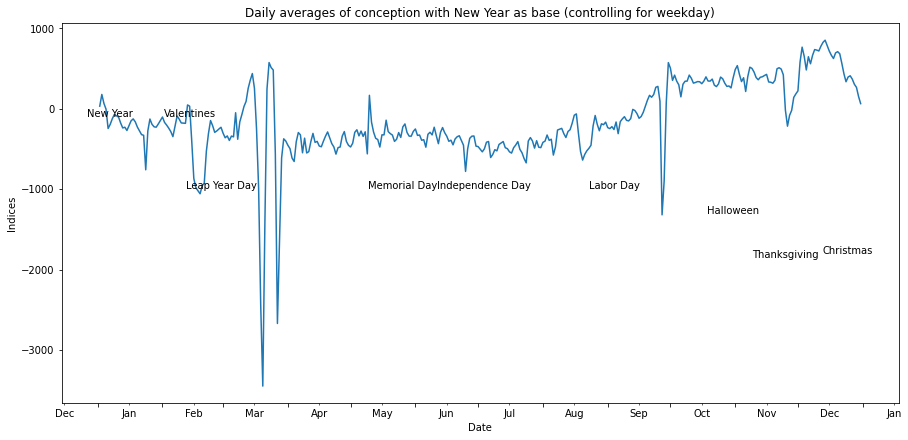

In [91]:
# Get date (pick leap year as placeholder)
data = results_df[7:]
data['date'] = pd.to_datetime('2012 ' + data['date'], format='%Y %b %d', errors='ignore')

# Plot
ax = sns.lineplot(x=data['date'], y=data['coefficient'])
ax.set(title='Daily averages of conception with New Year as base (controlling for weekday)', ylabel='Indices', xlabel='Date')

# day labels
ax.text(datetime.datetime(2012, 1, 7), -100, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), -100, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), -1000, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), -1000, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), -1000, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), -1000, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), -1300, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), -1850, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), -1800, "Christmas", ha='center')

# adjust x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

#### By two-week periods

In [31]:
# Get conceived dates
birth_df['conceived_start'] = birth_df['date'] - datetime.timedelta(days=280) #40 weeks
birth_df['conceived_end'] = birth_df['date'] - datetime.timedelta(days=266) #38 weeks
birth_df.head()

,year,month,day,births,date,conceived_date,dayofweek,conceived_start,conceived_end
0,1969,1,1,8486,1969-01-01,Jan 01,Wednesday,1968-03-27,1968-04-10
1,1969,1,2,9002,1969-01-02,Jan 02,Thursday,1968-03-28,1968-04-11
2,1969,1,3,9542,1969-01-03,Jan 03,Friday,1968-03-29,1968-04-12
3,1969,1,4,8960,1969-01-04,Jan 04,Saturday,1968-03-30,1968-04-13
4,1969,1,5,8390,1969-01-05,Jan 05,Sunday,1968-03-31,1968-04-14


In [32]:
birth_df['conceived_start'] = birth_df['conceived_start'].dt.strftime('%B %d')
birth_df['conceived_end'] = birth_df['conceived_end'].dt.strftime('%B %d')

data = birth_df.groupby(['conceived_start', 'conceived_end'])['births'].mean().reset_index(name='mean')

In [38]:
data.sort_values('mean', ascending=False)[:20]

,conceived_start,conceived_end,mean
63,December 03,December 17,11473.146341
70,December 10,December 24,11426.536585
73,December 13,December 27,11352.756098
77,December 17,December 31,11351.414634
69,December 09,December 23,11339.365854
76,December 16,December 30,11317.829268
74,December 14,December 28,11314.268293
75,December 15,December 29,11296.219512
72,December 12,December 26,11289.682927
71,December 11,December 25,11280.756098
